<a href="https://colab.research.google.com/github/CesarSarmiento1111/MetNumUN2024II/blob/main/LabATQ/Resultados_Lab_Quantiacs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Modificaciones principales

Dejé la cantidad de assets por defecto. Es decir, todos los assets posibles, lo que implica que son más de 20. No hay ninguna razón específica para esta decisión.

In [ ]:
stock_data = qndata.stocks_load_spx_data(min_date='2005-06-01')

Uso de "is_liquid", para usar solo los activos líquidos:  




In [ ]:
#Función get_features()
liq = data.sel(field="is_liquid").ffill("time").bfill("time").fillna(0)

# Expand liquidity to match dimensions of result
liq_expanded = liq.expand_dims(field=result.field)  # Match the "field" dimension

# Apply liquidity filter (assets with liq == 0 will be excluded)
result = result.where(liq_expanded > 0.5, drop=True)


Features añadidos:  
  
- TRIX: Captura tanto la tendencia a largo plazo como los cambios en la dirección de esa tendencia, filtrando el ruido del mercado. Ayuda a identificar cambios de momentum y evita reaccionar a movimientos insignificantes.

- ATR: Proporciona una medida clara de la volatilidad. Los activos con alta volatilidad pueden presentar mayores oportunidades o riesgos, y el ATR ayuda a reconocer estas ocasiones.

- OBV: Utiliza el volumen de transacciones para medir la presión de compra o venta acumulativa. un aumento en OBV junto con un alza en precios puede indicar acumulación, mientras que divergencias entre OBV y precio pueden ser señales de reversión.

In [ ]:
def get_features(data):
    """Builds the features used for learning:
       * a trend indicator;
       * the moving average convergence divergence;
       * a volatility measure;
       * the stochastic oscillator;
       * the relative strength index;
       * the logarithm of the closing price;
       * Trix indicator.
       * Average True Range (ATR);
       * On-Balance Volume (OBV).
       These features can be modified and new ones can be added easily.
    """

    # trend:
    #trend = qnta.roc(qnta.lwma(data.sel(field="close"), 60), 1)

    # Liquidity filter (1.0 for liquid assets, 0.0 for non-liquid assets):
    liq = data.sel(field="is_liquid").ffill("time").bfill("time").fillna(0)

    # moving average convergence divergence (MACD):
    macd = qnta.macd(data.sel(field="close"))
    macd2_line, macd2_signal, macd2_hist = qnta.macd(data, 12, 26, 9)

    # volatility:
    volatility = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
    volatility = volatility / data.sel(field="close")
    volatility = qnta.lwma(volatility, 14)

    # the stochastic oscillator:
    #k, d = qnta.stochastic(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14)

    # the relative strength index:
    rsi = qnta.rsi(data.sel(field="close"))

    # the logarithm of the closing price:
    #price = data.sel(field="close").ffill("time").bfill("time").fillna(0)  # fill NaN
    #price = np.log(price)

    # new feature: Trix (TRIX)
    trix = qnta.trix(data.sel(field="close"), 15)  # Using a period of 15 (can be adjusted)

    # new feature: Average True Range (ATR)
    atr = qnta.atr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14).expand_dims(field=["atr"])

    obv = qnta.obv(data.sel(field="close"), data.sel(field="vol")).expand_dims(field=["obv"])


    # combine the features:
    result = xr.concat(
        [macd2_signal.sel(field="close"), volatility, rsi, trix, atr, obv],
        pd.Index(
            ["macd", "volatility", "rsi", "trix", "atr", "obv"],
            name="field"
        )
    )

    # Expand liquidity to match dimensions of result
    liq_expanded = liq.expand_dims(field=result.field)  # Match the "field" dimension

    # Apply liquidity filter (assets with liq == 0 will be excluded)
    result = result.where(liq_expanded > 0.5, drop=True)


    return result.transpose("time", "field", "asset")

Los mercados financieros tienen una gran cantidad de patrones no lineales y complejos. Algoritmos como Gradient Boosting, y versiones derivadas de este, para el caso "Histogram Gradient Boosting", pueden reconocer interacciones complejas entre las variables sin que estas se especifiquen explícitamente, lo que los hace ideales para este tipo de problemas.

El modelo usado es Histogram Gradient Boosting, que es una versión de Gradient Boosting diseñada para ser más eficiente en términos de velocidad y consumo de memoria al trabajar con grandes conjuntos de datos. scikit-learn recomienda su uso en lugar de Gradient Boosting para conjuntos de datos mayores a 10,000 muestras.


In [ ]:
 #Función get_model()
 model = HistGradientBoostingClassifier()

Gráficas y Sharpe Ratio considerando que se compra, se vende y no se hace nada:

In [ ]:
def get_target_classes(data):
    """Target classes for predicting if price goes up, down, or stays the same."""

    # Calcular la variación porcentual diaria
    price_change_ratio = qnta.change(data.sel(field="close")) / data.sel(field="close")
    future_price_change_ratio = price_change_ratio.shift(time=-1).fillna(0)  # Manejo de NaNs

    # Definir clases
    class_positive = 1  # Price goes up more than move
    class_neutral = 0   # Price does not move more than move
    class_negative = -1 # Price goes down more than move


    move = 0.02  # 2%

    # Clasificar los rendimientos futuros
    target_price = xr.where(
        future_price_change_ratio < -move, class_negative, future_price_change_ratio
    )
    target_price = xr.where(
        future_price_change_ratio > move, class_positive, target_price
    )
    target_price = xr.where(abs(future_price_change_ratio) <= move, class_neutral, target_price)

    return target_price


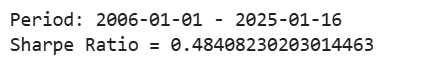

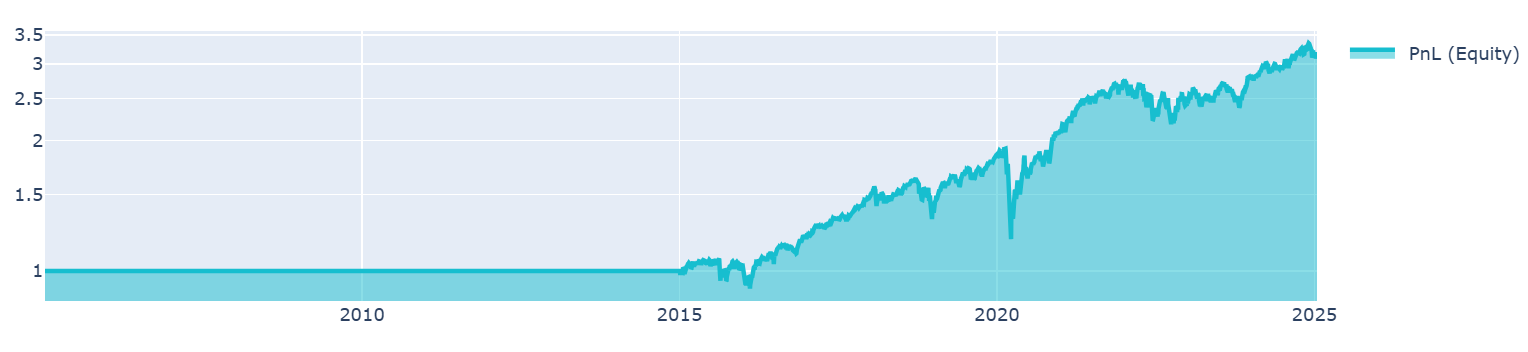

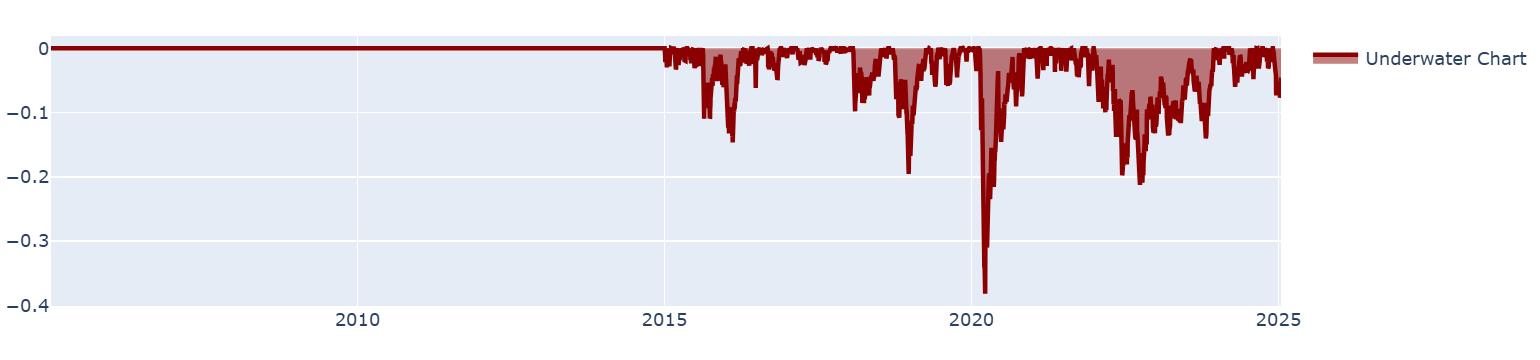

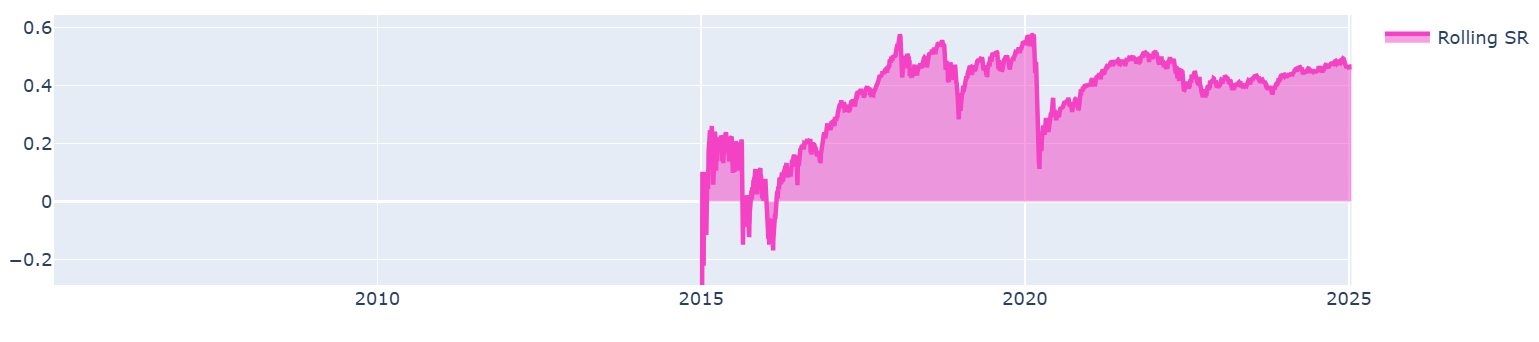

Gráficas y Sharpe Ratio considerando que se compra o no se hace nada:



In [ ]:
def get_target_classes(data):
    """ Target classes for predicting if price goes up or down."""

    price_current = data.sel(field="close")
    price_future  = qnta.shift(price_current, -1)

    class_positive = 1 # prices goes up
    class_negative = 0 # price goes down

    target_price_up = xr.where(price_future > price_current, class_positive, class_negative)

    return target_price_up

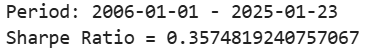

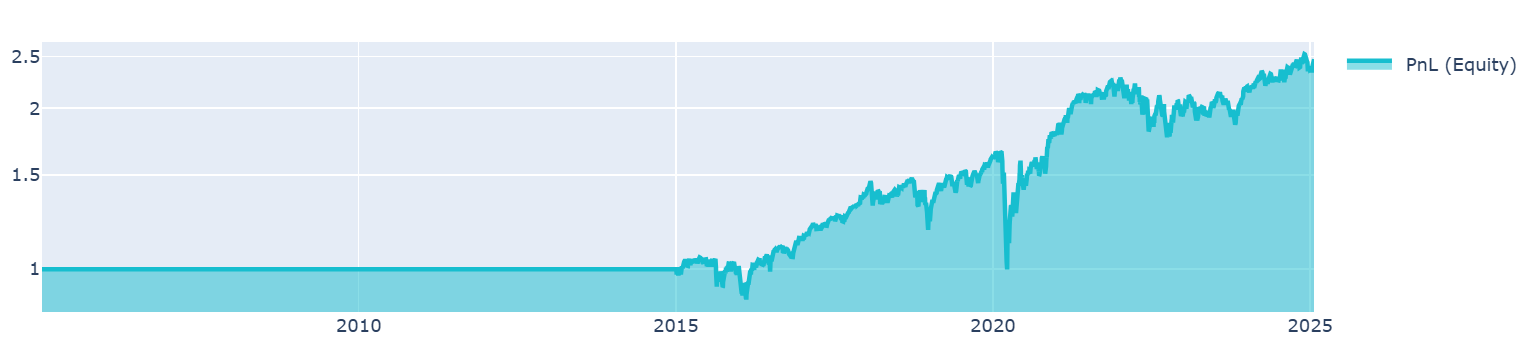

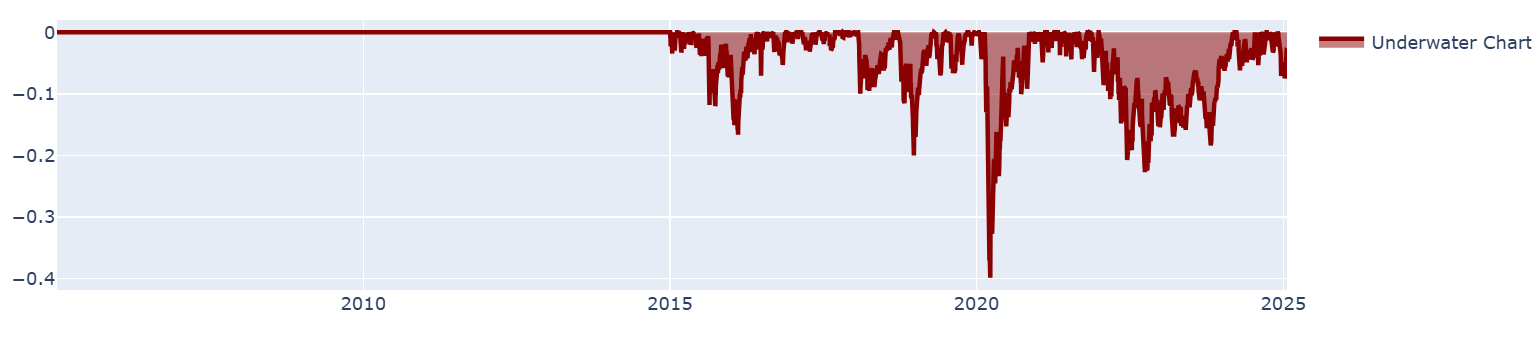

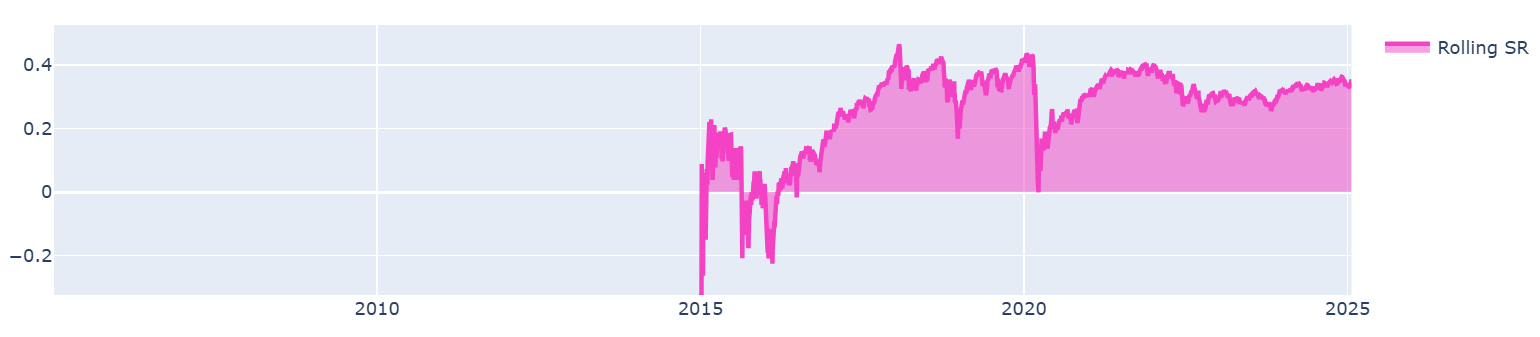

Gráficas y Sharpe Ratio considerando que se vende o no se hace nada:

In [ ]:
def get_target_classes(data):
    """Target classes for predicting if price goes down or stays the same/up."""

    price_current = data.sel(field="close")
    price_future  = qnta.shift(price_current, -1)

    class_down  = -1  # price goes down
    class_same  = 0   # price stays the same or goes up

    target_price_up = xr.where(price_future < price_current, class_down, class_same)

    return target_price_up

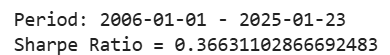

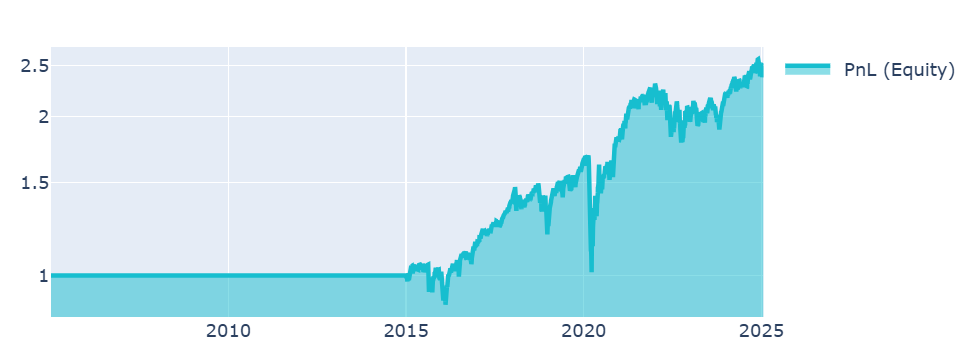

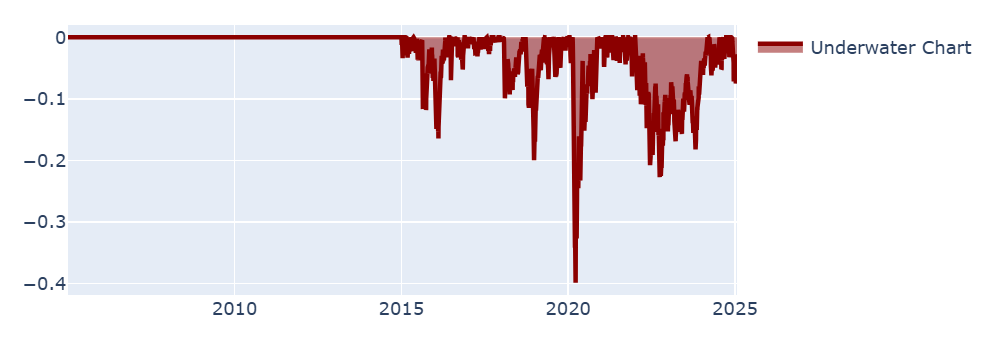

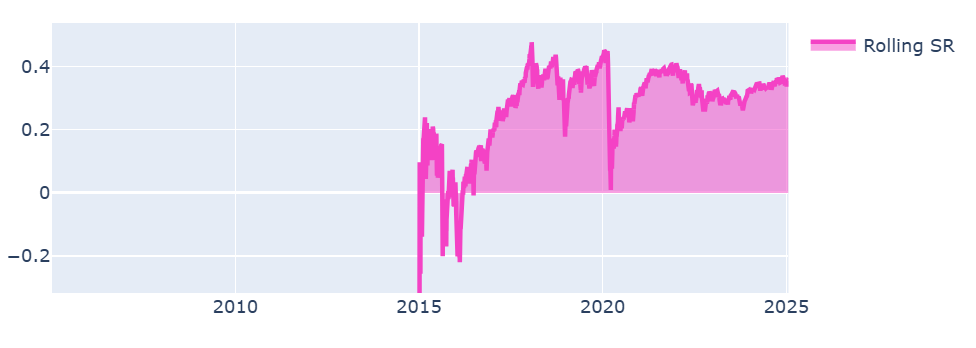